## Notebook utilisation de torch pour du MARL

Deuxime version du note book je vais jouer sur les hyperparametre l'utilisation d'autre modele, d'autre environement pour voir tous ce qu'il est possible de faire et comprendre comment l'adapter a mon cas.
Import de la bibliotheque torchrl et de l'ensemble des pakage nécessaire a un systeme multi agent qui tourne sur GPU

In [1]:
import torch

# Tensordict modules
from tensordict.nn import set_composite_lp_aggregate, TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import multiprocessing

# Data collection
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage

# Env
from torchrl.envs import RewardSum, TransformedEnv
from torchrl.envs.libs.vmas import VmasEnv
from torchrl.envs.utils import check_env_specs
from torchrl.envs.libs.pettingzoo import PettingZooEnv

# Multi-agent network
from torchrl.modules import MultiAgentMLP, ProbabilisticActor, TanhNormal

# Loss
from torchrl.objectives import ClipPPOLoss, ValueEstimators

# Utils
torch.manual_seed(0)
from matplotlib import pyplot as plt
from tqdm import tqdm

c:\Users\FX643778\AppData\Local\anaconda3\envs\pythorch_class\lib\site-packages\torchrl\data\replay_buffers\samplers.py:36: UserWarning: Failed to import torchrl C++ binaries. Some modules (eg, prioritized replay buffers) may not work with your installation. This is likely due to a discrepancy between your package version and the PyTorch version. Make sure both are compatible. Usually, torchrl majors follow the pytorch majors within a few days around the release. For instance, TorchRL 0.5 requires PyTorch 2.4.0, and TorchRL 0.6 requires PyTorch 2.5.0.
  warnings.warn(EXTENSION_WARNING)


Selection des hyperparametre pour l'entrainement on commence par definie avec quoi sera entrainer le modele (cpu ou gpu) en fonction de ce qui est disponible sue la machine si le gpu est diponible on va préferer l'utilise car ca permet de grandement accelerer l'apprentisage. Ensuite on a l'echantilonage le nombre d'action par bath le nombre d'iteration. Les hyperparamétre general de l'entrainement et ce spécifique a la methode PPO utilisé.

In [2]:
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)
print(device)

vmas_device = device

# Sampling
frames_per_batch = 6_000  # Number of team frames collected per training iteration
n_iters = 50  # Number of sampling and training iterations
total_frames = frames_per_batch * n_iters

# Training
num_epochs = 30  # Number of optimization steps per training iteration
minibatch_size = 400  # Size of the mini-batches in each optimization step
lr = 3e-4  # Learning rate
max_grad_norm = 1.0  # Maximum norm for the gradients

# PPO
clip_epsilon = 0.2  # clip value for PPO loss
gamma = 0.99  # discount factor
lmbda = 0.9  # lambda for generalised advantage estimation
entropy_eps = 1e-4  # coefficient of the entropy term in the PPO loss

# disable log-prob aggregation
set_composite_lp_aggregate(False).set()

cpu


Choix et parametrage de l'environement utiliser. Ici il s'agit de l'environement de navigation de Vmas.

In [3]:
max_steps = 1000  # Episode steps before done
num_vmas_envs = (
    frames_per_batch // max_steps
)  # Number of vectorized envs. frames_per_batch should be divisible by this number
scenario_name = "balance"
n_agents = 2


env = VmasEnv(
    scenario=scenario_name,
    num_envs=num_vmas_envs,
    continuous_actions=True,  # VMAS supports both continuous and discrete actions
    max_steps=max_steps,
    device=vmas_device,
    # Scenario kwargs
    n_agents=n_agents,
)

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [4]:
print("action_spec:", env.full_action_spec)
print("reward_spec:", env.full_reward_spec)
print("done_spec:", env.full_done_spec)
print("observation_spec:", env.observation_spec)

action_spec: Composite(
    agents: Composite(
        action: BoundedContinuous(
            shape=torch.Size([6, 2, 2]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([6, 2, 2]), device=cpu, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([6, 2, 2]), device=cpu, dtype=torch.float32, contiguous=True)),
            device=cpu,
            dtype=torch.float32,
            domain=continuous),
        device=cpu,
        shape=torch.Size([6, 2]),
        data_cls=None),
    device=cpu,
    shape=torch.Size([6]),
    data_cls=None)
reward_spec: Composite(
    agents: Composite(
        reward: UnboundedContinuous(
            shape=torch.Size([6, 2, 1]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([6, 2, 1]), device=cpu, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([6, 2, 1]), device=cpu, dtype=torch.float32, contiguous=True)),
            device=cpu,
 

In [5]:
print("action_keys:", env.action_keys)
print("reward_keys:", env.reward_keys)
print("done_keys:", env.done_keys)

action_keys: [('agents', 'action')]
reward_keys: [('agents', 'reward')]
done_keys: ['done', 'terminated']


Ajout d'une nouvelle sortie a l'environement. On somme les reward pour chaque agent au fils des iteration ca permet d'avoir un suivie des performence de l'agent a chaque étape de l'entrainement et donc pouvoir suivre si l'entrainement ce passe bien ou non.

In [6]:
env = TransformedEnv(
    env,
    RewardSum(in_keys=[env.reward_key], out_keys=[("agents", "episode_reward")]),
)

In [7]:
check_env_specs(env)

2025-07-31 13:59:11,159 [torchrl][INFO]    check_env_specs succeeded! [END]


Test pour voir la forme de la sortie dans une trajectoire complete (rollout). Ici la trajectoire fait 5 steps.

In [8]:
n_rollout_steps = 5
rollout = env.rollout(n_rollout_steps)
print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of three steps: TensorDict(
    fields={
        agents: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([6, 5, 2, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                episode_reward: Tensor(shape=torch.Size([6, 5, 2, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                info: TensorDict(
                    fields={
                        ground_rew: Tensor(shape=torch.Size([6, 5, 2, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                        pos_rew: Tensor(shape=torch.Size([6, 5, 2, 1]), device=cpu, dtype=torch.float32, is_shared=False)},
                    batch_size=torch.Size([6, 5, 2]),
                    device=cpu,
                    is_shared=False),
                observation: Tensor(shape=torch.Size([6, 5, 2, 16]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([6, 5, 2]),
            device=cpu,
            is_shared=False),
        

Parametrage du reseux utiliser pour l'apprentisage. On utilise le modele multi agent de torchrl et on configure les parametre d'apprentisage : nombre d'agent, décentraliser, une polituqye partager. Et la forme des sortie pour qu'elles s'adapte a notre modéle ici on utilise PPO donc pour chaque actionn il faut deux sorties une pour la moyenne et une pour l'écart type.

In [9]:
share_parameters_policy = True

policy_net = torch.nn.Sequential(
    MultiAgentMLP(
        n_agent_inputs=env.observation_spec["agents", "observation"].shape[
            -1
        ],  # n_obs_per_agent
        n_agent_outputs=2
        * env.full_action_spec[env.action_key].shape[-1],  # 2 * n_actions_per_agents
        # n_agents=env.n_agents,
        n_agents=kwargs["n_pistons"],
        centralised=False,  # the policies are decentralised (ie each agent will act from its observation)
        share_params=share_parameters_policy,
        device=device,
        depth=2,
        num_cells=256,
        activation_class=torch.nn.Tanh,
    ),
    NormalParamExtractor(),  # this will just separate the last dimension into two outputs: a loc and a non-negative scale
)

In [10]:
policy_module = TensorDictModule(
    policy_net,
    in_keys=[("agents", "observation")],
    out_keys=[("agents", "loc"), ("agents", "scale")],
)

In [11]:
policy = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec_unbatched,
    in_keys=[("agents", "loc"), ("agents", "scale")],
    out_keys=[env.action_key],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "low": env.full_action_spec_unbatched[env.action_key].space.low,
        "high": env.full_action_spec_unbatched[env.action_key].space.high,
    },
    return_log_prob=True,
)  # we'll need the log-prob for the PPO loss

In [12]:
share_parameters_critic = True
mappo = True  # IPPO if False

critic_net = MultiAgentMLP(
    n_agent_inputs=env.observation_spec["agents", "observation"].shape[-1],
    n_agent_outputs=1,  # 1 value per agent
    # n_agents=env.n_agents,
    n_agents=,
    centralised=mappo,
    share_params=share_parameters_critic,
    device=device,
    depth=2,
    num_cells=256,
    activation_class=torch.nn.Tanh,
)

critic = TensorDictModule(
    module=critic_net,
    in_keys=[("agents", "observation")],
    out_keys=[("agents", "state_value")],
)

In [13]:
print("Running policy:", policy(env.reset()))
print("Running value:", critic(env.reset()))

Running policy: TensorDict(
    fields={
        agents: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([6, 2, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                action_log_prob: Tensor(shape=torch.Size([6, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                episode_reward: Tensor(shape=torch.Size([6, 2, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                info: TensorDict(
                    fields={
                        ground_rew: Tensor(shape=torch.Size([6, 2, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                        pos_rew: Tensor(shape=torch.Size([6, 2, 1]), device=cpu, dtype=torch.float32, is_shared=False)},
                    batch_size=torch.Size([6, 2]),
                    device=cpu,
                    is_shared=False),
                loc: Tensor(shape=torch.Size([6, 2, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                observation

SyncDataCollector est un object de data collector qui est la pour faire fonctioner l'environement avec la politique.

In [14]:
collector = SyncDataCollector(
    env,
    policy,
    device=vmas_device,
    storing_device=device,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
)

Collecte les résultats de chaque pas pour les stocker. Dans ce cas la ce n'est pas nécessaire car on utilise PPO une methode on policy, donc en theorie il n'est pas nécessaire de mémoriser les données. Mais pour que le systeme soit adaptable et qu'il soit facile de changer la politique utiliser on le met. 

In [15]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(
        frames_per_batch, device=device
    ),  # We store the frames_per_batch collected at each iteration
    sampler=SamplerWithoutReplacement(),
    batch_size=minibatch_size,  # We will sample minibatches of this size
)

In [16]:
loss_module = ClipPPOLoss(
    actor_network=policy,
    critic_network=critic,
    clip_epsilon=clip_epsilon,
    entropy_coef=entropy_eps,
    normalize_advantage=False,  # Important to avoid normalizing across the agent dimension
)
loss_module.set_keys(  # We have to tell the loss where to find the keys
    reward=env.reward_key,
    action=env.action_key,
    value=("agents", "state_value"),
    # These last 2 keys will be expanded to match the reward shape
    done=("agents", "done"),
    terminated=("agents", "terminated"),
)


loss_module.make_value_estimator(
    ValueEstimators.GAE, gamma=gamma, lmbda=lmbda
)  # We build GAE
GAE = loss_module.value_estimator

optim = torch.optim.Adam(loss_module.parameters(), lr)

c:\Users\FX643778\AppData\Local\anaconda3\envs\pythorch_class\lib\site-packages\torchrl\objectives\ppo.py:450: DeprecationWarning: 'entropy_coef' is deprecated and will be removed in torchrl v0.11. Please use 'entropy_coeff' instead.
  warnings.warn(


In [17]:
pbar = tqdm(total=n_iters, desc="episode_reward_mean = 0")

episode_reward_mean_list = []
for tensordict_data in collector:
    tensordict_data.set(
        ("next", "agents", "done"),
        tensordict_data.get(("next", "done"))
        .unsqueeze(-1)
        .expand(tensordict_data.get_item_shape(("next", env.reward_key))),
    )
    tensordict_data.set(
        ("next", "agents", "terminated"),
        tensordict_data.get(("next", "terminated"))
        .unsqueeze(-1)
        .expand(tensordict_data.get_item_shape(("next", env.reward_key))),
    )
    # We need to expand the done and terminated to match the reward shape (this is expected by the value estimator)

    with torch.no_grad():
        GAE(
            tensordict_data,
            params=loss_module.critic_network_params,
            target_params=loss_module.target_critic_network_params,
        )  # Compute GAE and add it to the data

    data_view = tensordict_data.reshape(-1)  # Flatten the batch size to shuffle data
    replay_buffer.extend(data_view)

    for _ in range(num_epochs):
        for _ in range(frames_per_batch // minibatch_size):
            subdata = replay_buffer.sample()
            loss_vals = loss_module(subdata)

            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            loss_value.backward()

            torch.nn.utils.clip_grad_norm_(
                loss_module.parameters(), max_grad_norm
            )  # Optional

            optim.step()
            optim.zero_grad()

    collector.update_policy_weights_()

    # Logging
    done = tensordict_data.get(("next", "agents", "done"))
    episode_reward_mean = (
        tensordict_data.get(("next", "agents", "episode_reward"))[done].mean().item()
    )
    episode_reward_mean_list.append(episode_reward_mean)
    pbar.set_description(f"episode_reward_mean = {episode_reward_mean}", refresh=False)
    pbar.update()

episode_reward_mean = 100.9836196899414: 100%|██████████| 50/50 [12:35<00:00, 15.34s/it] 

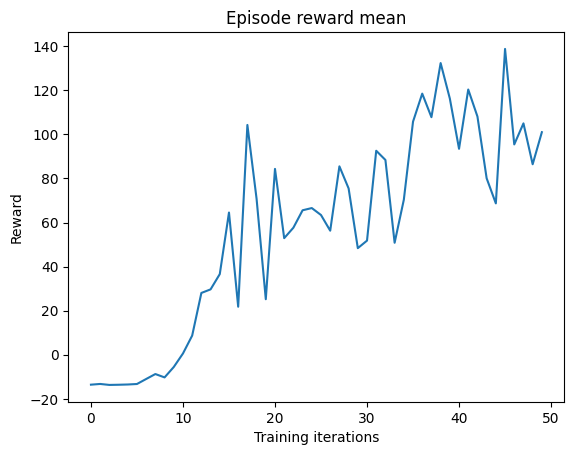

In [20]:
plt.plot(episode_reward_mean_list)
plt.xlabel("Training iterations")
plt.ylabel("Reward")
plt.title("Episode reward mean")
plt.show()

In [22]:
frame_count = 0
max_rendered_frames = 1000

def render_callback(env, _):
    global frame_count
    if frame_count < max_rendered_frames:
        env.render()
        frame_count += 1

env.rollout(
    max_steps=max_steps,
    policy=policy,
    callback=render_callback,
    auto_cast_to_device=True,
    break_when_any_done=False,
)


TensorDict(
    fields={
        agents: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([6, 1000, 2, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                action_log_prob: Tensor(shape=torch.Size([6, 1000, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                episode_reward: Tensor(shape=torch.Size([6, 1000, 2, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                info: TensorDict(
                    fields={
                        ground_rew: Tensor(shape=torch.Size([6, 1000, 2, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                        pos_rew: Tensor(shape=torch.Size([6, 1000, 2, 1]), device=cpu, dtype=torch.float32, is_shared=False)},
                    batch_size=torch.Size([6, 1000, 2]),
                    device=cpu,
                    is_shared=False),
                loc: Tensor(shape=torch.Size([6, 1000, 2, 2]), device=cpu, dtype=torch.float32, is_shared=False),
 

: 

In [ ]:
import torch
import numpy as np
from pettingzoo.mpe import simple_spread_v3

env = simple_spread_v3.env(render_mode="human", continuous_actions=True)
env.reset()

obs_vide = torch.zeros(18, dtype=torch.float32)
obs_agent0 = obs_vide.clone()
obs_agent1 = obs_vide.clone()
obs_agent2 = obs_vide.clone()

sum_reward = 0

for agent in env.agent_iter():
    env.render()
    observation, reward, termination, truncation, info = env.last()
    sum_reward += reward / 3  # Moyenne simple entre 3 agents

    if termination or truncation:
        action = None
    else:
        # Action aléatoire de l'agent actif
        action = env.action_space(agent).sample()
        

        # Mise à jour des observations (facultatif ici, mais utile si tu veux les afficher)
        obs = torch.tensor(observation, dtype=torch.float32)
        if agent == "agent_0":
            obs_agent0 = obs
        elif agent == "agent_1":
            obs_agent1 = obs
        elif agent == "agent_2":
            obs_agent2 = obs

        print(f"{agent} -> action aléatoire : {action}")

    env.step(action)

env.close()
print("Total reward (somme sur tous les agents, normalisée) :", sum_reward)


agent_0 -> action aléatoire : [0.23824263 0.49061593 0.2755846  0.8542123  0.8882865 ]
agent_1 -> action aléatoire : [0.14897706 0.7427515  0.6990683  0.7407246  0.03634968]
agent_2 -> action aléatoire : [0.89305794 0.4516947  0.55527115 0.04877529 0.7884043 ]
agent_0 -> action aléatoire : [0.09523629 0.54154533 0.6897011  0.18387054 0.28986958]
agent_1 -> action aléatoire : [0.5991937  0.7659306  0.01936371 0.35354733 0.282225  ]
agent_2 -> action aléatoire : [0.770443   0.396678   0.3703459  0.39468762 0.24586804]
agent_0 -> action aléatoire : [0.59473264 0.24170512 0.74438614 0.666603   0.6976572 ]
agent_1 -> action aléatoire : [0.5171431  0.64193016 0.11293946 0.5451091  0.35189053]
agent_2 -> action aléatoire : [0.9928223  0.81476974 0.90205145 0.4341866  0.4594253 ]
agent_0 -> action aléatoire : [0.5779388  0.06964643 0.63765526 0.67694247 0.28368926]
agent_1 -> action aléatoire : [0.31426358 0.92743313 0.4807602  0.66364884 0.34714282]
agent_2 -> action aléatoire : [0.5335299  0